# Predicting Job Advertisement Performance Using Aggregated Recruitment Data

## 1. Project Overview

The goal of this project is to analyze job advertisement performance data and explore opportunities for predictive analytics.  
The primary focus is **data aggregation, data preparation, and data analysis**, rather than building the most accurate machine learning model.

The project investigates whether characteristics such as **job title, standardized job category, city, and posting date** can be used to predict engagement-related metrics such as:

- Apply Start Rate (ASR)
- Clickthrough Rate (CTR)

Several modeling approaches are evaluated to understand **data limitations, leakage risks, and model suitability**.

---

## 2. Data Aggregation

### 2.1 Data Sources

Two datasets were used in this project:

1. **Indeed campaign performance dataset (`indeed.csv`)**
   - Contains job-level performance metrics such as impressions, clicks, applies, and costs.
   - Semi-structured CSV format with European number formatting.

2. **Job title standardization dataset (`Map2.csv`)**
   - Enriched version of the original dataset.
   - Adds a *standardized job title* column created externally in Excel.
   - Allows aggregation of similar job titles under a common category.

### 2.2 Aggregation Process

- Both datasets originate from the recruitment reporting pipeline.
- The standardized dataset (`Map2.csv`) represents a **data enrichment step**, combining:
  - Original job performance metrics
  - Manually curated standardized job titles

This aggregation improves consistency and reduces categorical fragmentation.

---

## 3. Data Preparation

Data preparation was performed using **repeatable and transparent steps**, ensuring suitability for analysis.

### 3.1 Column Cleaning and Renaming

- Column names were standardized:
  - Spaces removed
  - Special characters replaced
- Ensures compatibility with Python libraries and reproducibility.

### 3.2 Data Quality Handling

The following data quality issues were addressed:

- **Missing values**
  - Rows with missing target values were removed.
  - Rows missing essential categorical features (Job, City, Standard) were removed.
- **Date parsing**
  - Posting dates were converted to datetime format.
  - Invalid dates were excluded.

### 3.3 Feature Engineering

Derived features were created from the posting date:

- Posting month
- Posting weekday
- Posting quarter
- Week of year

These features enable **temporal trend analysis**.

### 3.4 Outlier and Threshold Handling

To reduce noise:
- Impressions below a minimum threshold (e.g., 30) were optionally excluded.
- Extremely high ratio values were removed to avoid distortion.

This improves stability without altering the underlying data-generating process.

---

## 4. Exploratory Data Analysis (EDA)

### 4.1 Descriptive Analytics

Basic descriptive statistics were examined:
- Distribution of CTR and ASR
- Frequency of job titles and cities
- Variability across standardized job categories

### 4.2 Aggregated Analysis

- Average CTR and ASR were calculated per city and per job category.
- Visualization showed strong variation across categories but high variance within them.

### 4.3 Feature Importance Analysis

Feature importance was aggregated at the variable level:

- Job / Standardized Job
- City
- Temporal features

Results consistently showed:
- Most signal comes from **categorical identity**
- Temporal features contribute very little

This insight directly influenced model selection.

---

## 5. Modeling Strategy and Experiments

The modeling process followed an **iterative and reflective approach**, with each step building on insights from previous experiments.

---

### 5.1 Experiment 1 – Random Forest with Data Leakage (Invalid)

**Target:** Apply Start Rate (ASR)  
**Features:** Included clicks, impressions, applies, spend, etc.

- Produced extremely high R² scores (> 0.99)
- Identified as **data leakage**, as ASR is derived from these features

**Conclusion:**  
This experiment is intentionally included to demonstrate awareness of leakage and is excluded from further evaluation.

---

### 5.2 Experiment 2 – Random Forest with Realistic Features

**Target:** Apply Start Rate (ASR)  
**Features:** Job, City, posting date features

- Performance close to zero R²
- Indicates ASR is highly volatile and difficult to predict

---

### 5.3 Experiment 3 – Random Forest with Standardized Job Titles

**Target:** Apply Start Rate (ASR)  
**Features:** Job, City, Standard

- Slight improvement compared to Experiment 2
- Still poor generalization due to limited data per category

**Insight:**  
Standardization improves data quality but does not fully solve sparsity.

---

### 5.4 Experiment 4 – Random Forest with CTR (Best RF Result)

**Target:** Clickthrough Rate (CTR)  
**Features:** Job, City, Standard, date features

- CTR proved more predictable than ASR
- Still limited generalization due to small dataset and categorical sparsity

---

### 5.5 Experiment 5 – XGBoost

**Target:** CTR  
**Outcome:**
- Very high training R²
- Poor test and cross-validation performance

**Conclusion:**  
XGBoost overfits due to:
- Small dataset
- High-cardinality categorical variables
- Noise in ratio-based targets

---

### 5.6 Experiment 6 – Ridge Regression (Best Overall Model)

**Target:** CTR  
**Model:** Ridge Regression with one-hot encoded categorical features

**Results:**
- Best test R² among valid models
- Lower variance compared to RF and XGBoost
- More stable predictions

**Why Ridge works best:**
- Linear assumptions fit the weak signal
- L2 regularization reduces overfitting
- Handles sparse categorical data more robustly

---

## 6. Cross-Validation Analysis

Across all experiments, cross-validated R² scores were low or negative.

This behavior is expected because:
- The dataset is small
- Many categories appear only once
- Some validation folds contain unseen categories

Negative CV R² indicates **instability caused by data limitations**, not incorrect modeling.

Cross-validation therefore supports the conclusion that **more data or stronger aggregation is required**.

---

## 7. Opportunities for Predictive Analytics

Based on the analysis, the following opportunities were identified:

- **CTR is more predictable than ASR**
- Aggregating job titles into standardized categories improves signal
- City-level patterns show consistent differences in engagement
- Linear models with regularization are better suited for sparse recruitment data

### Impact Forecast

With additional data (more postings per job category and city):
- Predictive stability would increase
- Non-linear models could become viable
- Forecasting job ad performance before publishing would become feasible

---

## 8. Limitations

- Small dataset size
- High cardinality categorical variables
- Behavioral ratios (CTR, ASR) introduce noise
- Manual job standardization limits scalability

---

## 9. Conclusion

This project demonstrates the full data analytics pipeline:

- Data aggregation from multiple sources
- Transparent and repeatable data preparation
- Exploratory and descriptive analysis
- Identification of predictive opportunities
- Critical evaluation of model performance and limitations

The main conclusion is that **data quality and quantity are the primary constraints**, not model choice.  
Ridge Regression provides the most appropriate balance between bias and variance for the available data.

---

## 10. Final Reflection

The project highlights the importance of:
- Avoiding data leakage
- Matching model complexity to data quality
- Using evaluation metrics responsibly
- Understanding when predictive modeling is limited by the data itself

In [1]:
import pandas as pd

df = pd.read_csv(
    "indeed.csv",
    sep=";",
    encoding="latin1"
)

df.head()



,Job,Country,State/Region,City,Impressions,Clicks,Apply starts,Applies,Cost per click (CPC),Cost per apply start (CPAS),Cost per apply (CPA),Clickthrough rate (CTR),Apply completion rate (ACR),Apply start rate (ASR),Apply rate (AR),Spend,Last updated,Created
0,(Junior) Werkvoorbereider,Netherlands,Zeeland,NaN,81,8,0,0,0,0,0,0.098765,0,0.000000,0,0,30-10-2025,30-9-2025
1,(Senior) Project Manager,Netherlands,Noord-Holland,Amsterdam,362,59,7,0,0.2016949152542373,1.7,0,0.162983,0,0.118644,0,11.9,22-5-2025,15-5-2025
2,Accountmanager,Netherlands,Utrecht (provincie),Amersfoort,543,51,1,0,0.22,11.22,0,0.093923,0,0.019608,0,11.22,22-5-2025,16-5-2025
3,Accountmanager,Netherlands,Utrecht (provincie),Amersfoort,291,26,0,0,0,0,0,0.089347,0,0.000000,0,0,22-5-2025,16-5-2025
4,Accountmanager,Netherlands,Utrecht (provincie),Amersfoort,223,29,2,0,0.27620689655172415,4.005,0,0.130045,0,0.068966,0,8.01,22-5-2025,16-5-2025


## Test 1 – Random Forest with Leaking Features (Invalid Baseline)

### Objective
Establish an initial baseline model and explore predictive potential.

### Target
- Apply Start Rate (ASR)

### Features
- Job and location data
- Campaign performance metrics (impressions, clicks, applies, spend)

### Results
- Train R² ≈ 0.99  
- Test R² ≈ 0.99  

### Interpretation
These unrealistically high scores indicate **data leakage**.  
ASR is mathematically derived from features included in the model.

### Conclusion
This model is invalid and excluded from further consideration.  
However, it is included intentionally to demonstrate awareness of data leakage risks.

First 5 rows:
                          Job      Country         State/Region        City  \
0  (Junior) Werkvoorbereider  Netherlands              Zeeland         NaN   
1   (Senior) Project Manager  Netherlands        Noord-Holland   Amsterdam   
2             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   
3             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   
4             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   

   Impressions  Clicks  Apply starts  Applies Cost per click (CPC)  \
0           81       8             0        0                    0   
1          362      59             7        0   0.2016949152542373   
2          543      51             1        0                 0.22   
3          291      26             0        0                    0   
4          223      29             2        0  0.27620689655172415   

  Cost per apply start (CPAS)  Cost per apply (CPA)  Clickthrough rate (CTR)  \
0              

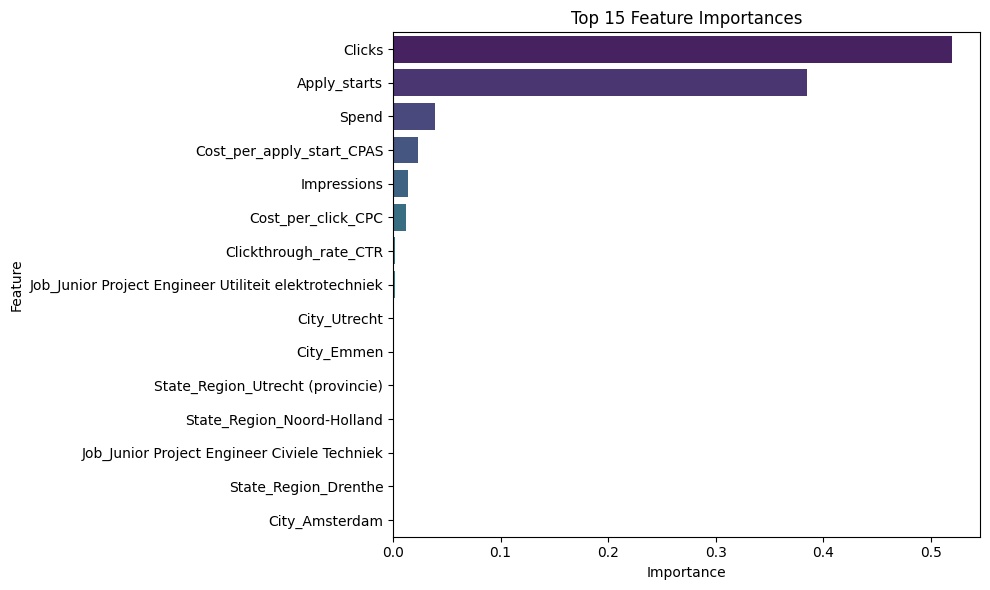

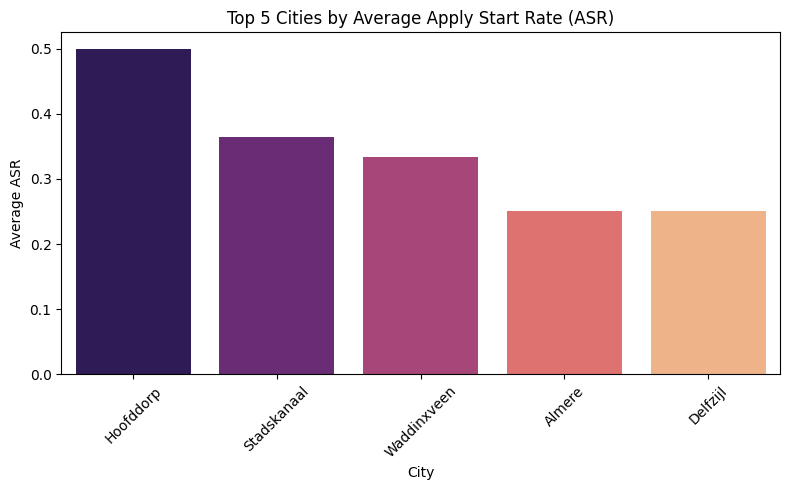

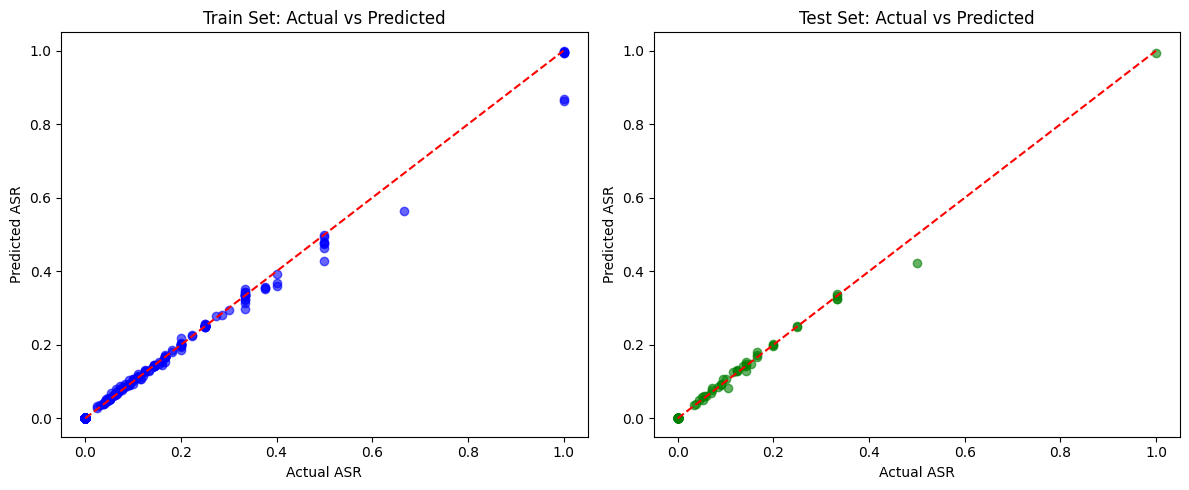

In [ ]:
#incorrect model try #1

# Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# =========================
# Load dataset
# =========================
df = pd.read_csv(
    "indeed.csv",
    sep=";",
    encoding="latin1"
)

# =========================
# Initial exploration
# =========================
print("First 5 rows:\n", df.head())
print("\nColumns:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())

# =========================
# Rename columns (for simplicity, remove spaces and special characters)
# =========================
df = df.rename(columns=lambda x: x.strip().replace(" ", "_")
                                  .replace("/", "_")
                                  .replace("(", "")
                                  .replace(")", ""))
print("\nRenamed columns:\n", df.columns)

# =========================
# Drop duplicates
# =========================
df = df.drop_duplicates()
print(f"\nNumber of rows after removing duplicates: {df.shape[0]}")

# =========================
# Handle missing target
# =========================
target = "Apply_start_rate_ASR"  # after renaming
df = df.dropna(subset=[target])

# =========================
# Handle missing numerical features
# =========================
numerical_features = [
    "Impressions", "Clicks", "Apply_starts", "Applies",
    "Cost_per_click_CPC", "Cost_per_apply_start_CPAS",
    "Cost_per_apply_CPA", "Clickthrough_rate_CTR",
    "Apply_completion_rate_ACR", "Apply_rate_AR", "Spend"
]

# Fill missing numerical values with median
for col in numerical_features:
    df[col] = df[col].astype(str)  # ensure string first for cleaning
    df[col] = df[col].str.replace(".", "", regex=False)  # remove thousands separator
    df[col] = df[col].str.replace(",", ".", regex=False)  # convert decimal comma
    df[col] = pd.to_numeric(df[col], errors="coerce")  # convert to float
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# =========================
# Handle missing categorical features
# =========================
categorical_features = ["Job", "Country", "State_Region", "City"]
for col in categorical_features:
    df[col] = df[col].astype(str).str.strip()  # remove extra spaces
    df[col] = df[col].fillna("Unknown")  # fill missing with placeholder

# =========================
# Remove outliers
# =========================
# Here, remove rows where Impressions > 3 standard deviations
for col in ["Impressions", "Clicks", "Apply_starts"]:
    mean = df[col].mean()
    std = df[col].std()
    df = df[(df[col] >= mean - 3*std) & (df[col] <= mean + 3*std)]

# =========================
# Train-test split
# =========================
X = df[categorical_features + numerical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# Preprocessing
# =========================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

# =========================
# Random Forest model
# =========================
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# =========================
# Pipeline
# =========================
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", rf_model)
    ]
)

# =========================
# Train model
# =========================
model.fit(X_train, y_train)

# =========================
# Evaluation (Train & Test)
# =========================
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train metrics
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\n--- Model Evaluation ---")
print(f"Train R² score: {r2_train:.4f}")
print(f"Train Mean Squared Error (MSE): {mse_train:.4f}")
print(f"Test R² score: {r2_test:.4f}")
print(f"Test Mean Squared Error (MSE): {mse_test:.4f}")

# =========================================================
# Cross-validation (stability check)
# =========================================================
cv_scores = cross_val_score(
    model, X, y,
    cv=5,
    scoring="r2"
)

print("\nCross-validated R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

# =========================
# Feature importance
# =========================
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([cat_feature_names, numerical_features])

importances = model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), hue=feature_importance_df.head(15)['Feature'], legend=False, palette="viridis")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# =========================
# Top 5 Cities by Average ASR
# =========================
top_cities = df.groupby("City")[target].mean().sort_values(ascending=False).head(5)
plt.figure(figsize=(8,5))
sns.barplot(x=top_cities.index, y=top_cities.values, hue=top_cities.index, legend=False, palette="magma")
plt.title("Top 5 Cities by Average Apply Start Rate (ASR)")
plt.ylabel("Average ASR")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# Predicted vs Actual Plot (Train + Test)
# =========================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual ASR")
plt.ylabel("Predicted ASR")
plt.title("Train Set: Actual vs Predicted")

plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual ASR")
plt.ylabel("Predicted ASR")
plt.title("Test Set: Actual vs Predicted")

plt.tight_layout()
plt.show()


## Test 2 – Random Forest with Realistic Features (No Standardization)

### Objective
Evaluate whether ASR can be predicted using only realistic, pre-publication features.

### Target
- Apply Start Rate (ASR)

### Features
- Job
- City
- Posting date features

### Results
- Train R² ≈ 0.07  
- Test R² ≈ 0.01  
- Mean CV R² < 0  

### Interpretation
The model fails to generalize.  
ASR is highly volatile and influenced by unobserved factors such as:
- Job description quality
- Employer brand
- Market competition

### Conclusion
ASR is not a suitable target given the available data.

First 5 rows:
                          Job      Country         State/Region        City  \
0  (Junior) Werkvoorbereider  Netherlands              Zeeland         NaN   
1   (Senior) Project Manager  Netherlands        Noord-Holland   Amsterdam   
2             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   
3             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   
4             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   

   Impressions  Clicks  Apply starts  Applies Cost per click (CPC)  \
0           81       8             0        0                    0   
1          362      59             7        0   0.2016949152542373   
2          543      51             1        0                 0.22   
3          291      26             0        0                    0   
4          223      29             2        0  0.27620689655172415   

  Cost per apply start (CPAS)  Cost per apply (CPA)  Clickthrough rate (CTR)  \
0              

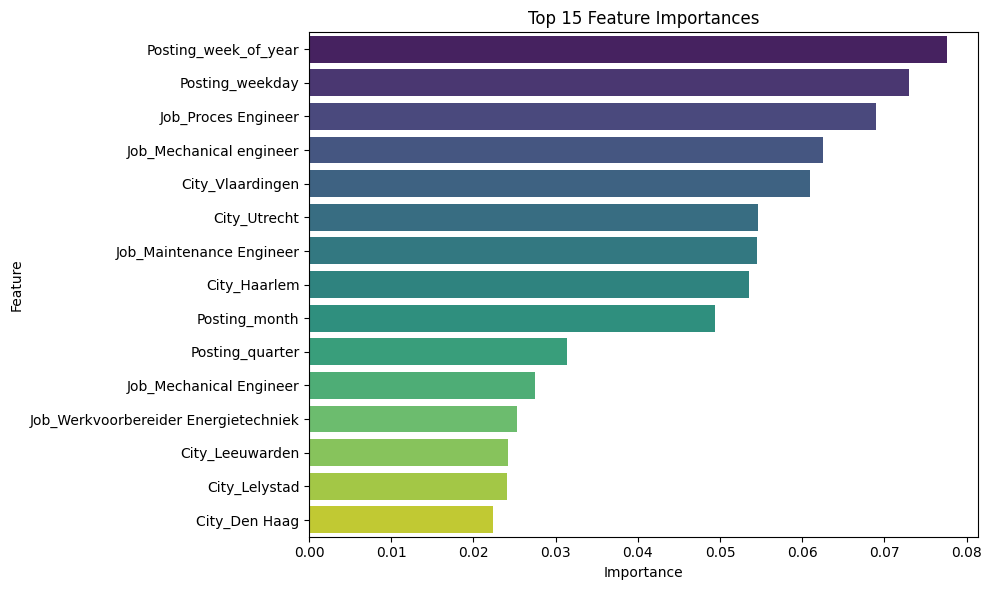

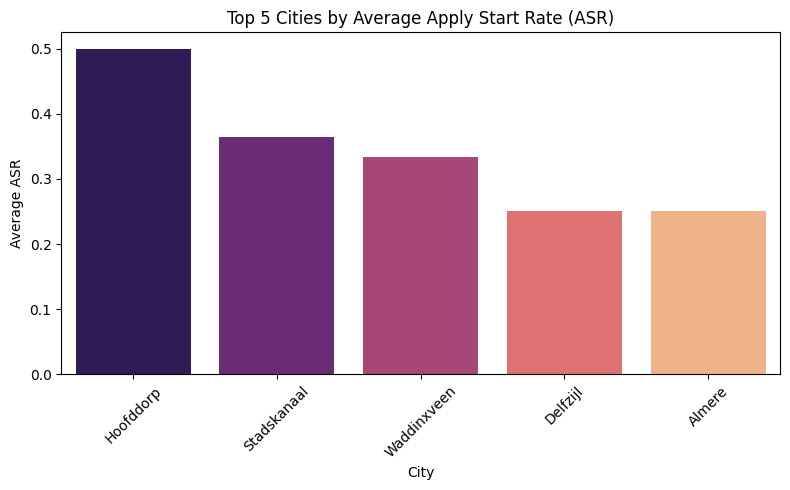

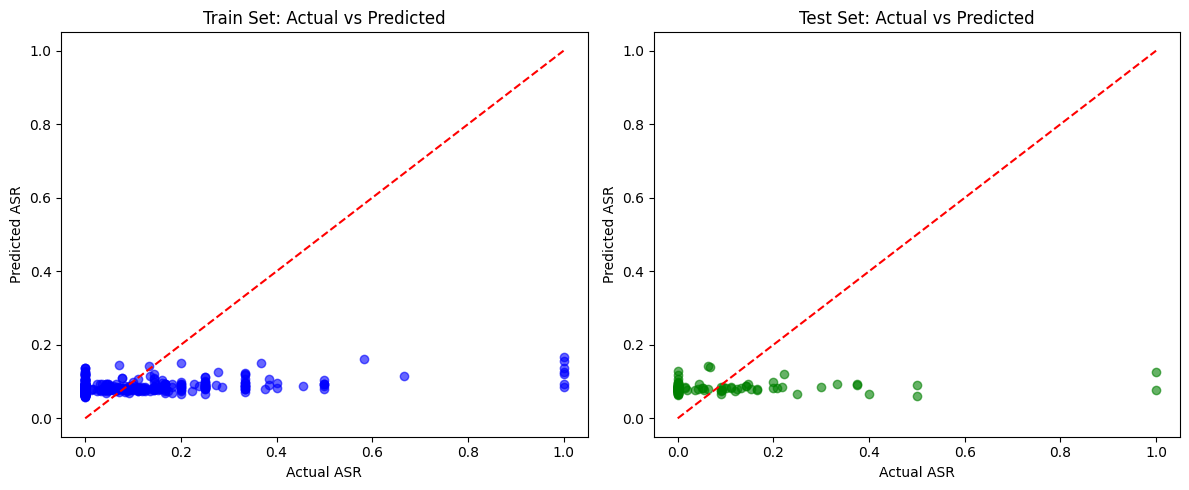

In [ ]:
# Corrected but without standard

# =========================
# Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# =========================
# Load dataset
# =========================
df = pd.read_csv(
    "indeed.csv",
    sep=";",
    encoding="latin1"
)

# =========================
# Initial exploration
# =========================
print("First 5 rows:\n", df.head())
print("\nColumns:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())

# =========================
# 4. Rename columns (for simplicity, remove spaces and special characters)
# =========================
df = df.rename(columns=lambda x: x.strip().replace(" ", "_")
                                  .replace("/", "_")
                                  .replace("(", "")
                                  .replace(")", ""))
print("\nRenamed columns:\n", df.columns)

# =========================
# Drop duplicates
# =========================
df = df.drop_duplicates()
print(f"\nNumber of rows after removing duplicates: {df.shape[0]}")

# =========================
# Keep only realistic features
# =========================
categorical_features = ["Job", "City"]
target = "Apply_start_rate_ASR"

# =========================================================
# Data quality filtering
# =========================================================

# Convert Created to datetime
df["Created"] = pd.to_datetime(df["Created"], errors="coerce", dayfirst=True)

# Drop rows with invalid dates
df = df.dropna(subset=["Created", target])

# =========================
# Feature engineering from date
# =========================
df["Posting_month"] = df["Created"].dt.month
df["Posting_weekday"] = df["Created"].dt.weekday
df["Posting_quarter"] = df["Created"].dt.quarter
df["Posting_week_of_year"] = df["Created"].dt.isocalendar().week

numerical_features = [
    "Posting_month",
    "Posting_weekday",
    "Posting_quarter",
    "Posting_week_of_year"
]

# =========================
# Handle missing categorical values
# =========================
for col in categorical_features:
    df[col] = df[col].astype(str).str.strip() # remove extra spaces
    df[col] = df[col].fillna("Unknown") # fill missing with placeholder

# =========================
# Train-test split
# =========================
X = df[categorical_features + numerical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# Preprocessing
# =========================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

# =========================
# Random Forest model (tuned)
# =========================
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,           # limit depth
    max_features="sqrt",   # consider sqrt features per split
    min_samples_leaf=3,    # min samples per leaf
    random_state=42,
    n_jobs=-1
)

# =========================
# Pipeline
# =========================
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", rf_model)
    ]
)

# =========================
# Train model
# =========================
model.fit(X_train, y_train)

# =========================
# Evaluation
# =========================
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train metrics
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\n--- Model Evaluation ---")
print(f"Train R² score: {r2_train:.4f}")
print(f"Train Mean Squared Error (MSE): {mse_train:.6f}")
print(f"Test R² score: {r2_test:.4f}")
print(f"Test Mean Squared Error (MSE): {mse_test:.6f}")

# =========================================================
# Cross-validation (stability check)
# =========================================================
cv_scores = cross_val_score(
    model, X, y,
    cv=5,
    scoring="r2"
)

print("\nCross-validated R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

# =========================
# Feature importance
# =========================
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([cat_feature_names, numerical_features])

importances = model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), hue=feature_importance_df.head(15)['Feature'], legend=False, palette="viridis")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# =========================
# Top 5 Cities by Average ASR
# =========================
top_cities = df.groupby("City")[target].mean().sort_values(ascending=False).head(5)
plt.figure(figsize=(8,5))
sns.barplot(x=top_cities.index, y=top_cities.values, hue=top_cities.index, legend=False, palette="magma")
plt.title("Top 5 Cities by Average Apply Start Rate (ASR)")
plt.ylabel("Average ASR")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# Predicted vs Actual Plot (Train + Test)
# =========================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual ASR")
plt.ylabel("Predicted ASR")
plt.title("Train Set: Actual vs Predicted")

plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual ASR")
plt.ylabel("Predicted ASR")
plt.title("Test Set: Actual vs Predicted")

plt.tight_layout()
plt.show()



Aggregated Feature Importance:
   Feature  Importance
1     City    0.389623
0      Job    0.379041
2  Created    0.153761


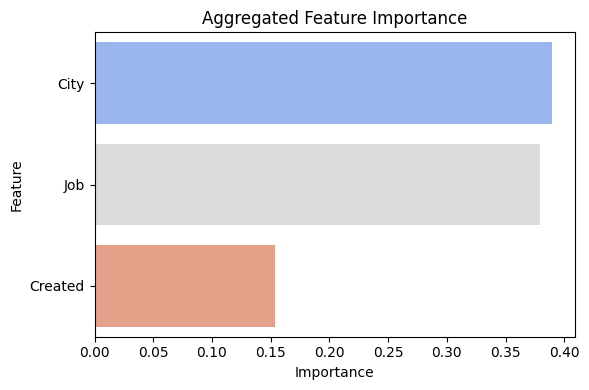

In [4]:

# =========================
# Aggregate importance by main variable
# =========================

# Identify dummy prefixes
job_cols = [f for f in all_feature_names if f.startswith("Job_")]
city_cols = [f for f in all_feature_names if f.startswith("City_")]
created_cols = ["Posting_month", "Posting_weekday", "Posting_quarter"]

# Helper function to sum importance safely
def sum_importance(cols, feature_names, importances):
    idx = [np.where(feature_names == c)[0][0] for c in cols if c in feature_names]
    return importances[idx].sum() if len(idx) > 0 else 0

# Sum importance per variable
job_importance = sum_importance(job_cols, all_feature_names, importances)
city_importance = sum_importance(city_cols, all_feature_names, importances)
created_importance = sum_importance(created_cols, all_feature_names, importances)

# Create dataframe
agg_importance_df = pd.DataFrame({
    "Feature": ["Job", "City", "Created"],
    "Importance": [
        job_importance,
        city_importance,
        created_importance
    ]
}).sort_values(by="Importance", ascending=False)

print("\nAggregated Feature Importance:")
print(agg_importance_df)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(
    x="Importance",
    y="Feature",
    data=agg_importance_df,
    hue="Feature",
    legend=False,
    palette="coolwarm"
)
plt.title("Aggregated Feature Importance")
plt.tight_layout()
plt.show()



In [5]:
import pandas as pd

df = pd.read_csv(
    "Map2.csv",
    sep=";",
    encoding="latin1"
)

df.head()

,Job,Standard,Country,State/Region,City,Impressions,Clicks,Apply starts,Applies,Cost per click (CPC),...,Apply completion rate (ACR),Apply start rate (ASR),Apply rate (AR),Spend,Last updated,Created,Unnamed: 19,Unnamed: 20,Functietitel,Gestandaardiseerde titel
0,Accountmanager,Accountmanager,Netherlands,Utrecht (provincie),Amersfoort,543.0,51.0,1.0,0.0,0.22,...,0.0,0.019608,0.0,11.22,22-5-2025,16-5-2025,NaN,NaN,.NET Developer,NaN
1,Accountmanager,Accountmanager,Netherlands,Utrecht (provincie),Amersfoort,291.0,26.0,0.0,0.0,0,...,0.0,0.000000,0.0,0,22-5-2025,16-5-2025,NaN,NaN,Accountmanager Detachering,NaN
2,Accountmanager,Accountmanager,Netherlands,Utrecht (provincie),Amersfoort,223.0,29.0,2.0,0.0,0.27620689655172415,...,0.0,0.068966,0.0,8.01,22-5-2025,16-5-2025,NaN,NaN,Agile Coach,NaN
3,Traineeship Technische Bedrijfskunde,Bedrijfsbeheerder,Netherlands,Overijssel,Steenwijk,72.0,4.0,0.0,0.0,0,...,0.0,0.000000,0.0,0,22-5-2025,6-5-2025,NaN,NaN,Assistent uitvoerder civiel,NaN
4,Traineeship Technische Bedrijfskunde,Bedrijfsbeheerder,Netherlands,Noord-Holland,Schagen,74.0,6.0,0.0,0.0,0,...,0.0,0.000000,0.0,0,22-5-2025,6-5-2025,NaN,NaN,Business Analyst,NaN


## Test 3 – Random Forest with Standardized Job Titles

### Objective
Improve predictive signal by reducing categorical noise in job titles.

### Target
- Apply Start Rate (ASR)

### Features
- Job
- City
- Standardized Job Title
- Posting date features

### Results
- Slight improvement over Test 2
- Still low and unstable CV R²

### Interpretation
Standardization improves data quality but does not solve:
- Limited observations per category
- High variance in user behavior

### Conclusion
Target remains too noisy.  
Focus shifts from ASR to CTR.

First 5 rows:
                                     Job           Standard      Country  \
0                        Accountmanager     Accountmanager  Netherlands   
1                        Accountmanager     Accountmanager  Netherlands   
2                        Accountmanager     Accountmanager  Netherlands   
3  Traineeship Technische Bedrijfskunde  Bedrijfsbeheerder  Netherlands   
4  Traineeship Technische Bedrijfskunde  Bedrijfsbeheerder  Netherlands   

          State/Region        City  Impressions  Clicks  Apply starts  \
0  Utrecht (provincie)  Amersfoort        543.0    51.0           1.0   
1  Utrecht (provincie)  Amersfoort        291.0    26.0           0.0   
2  Utrecht (provincie)  Amersfoort        223.0    29.0           2.0   
3           Overijssel   Steenwijk         72.0     4.0           0.0   
4        Noord-Holland     Schagen         74.0     6.0           0.0   

   Applies Cost per click (CPC)  ... Apply completion rate (ACR)  \
0      0.0                 

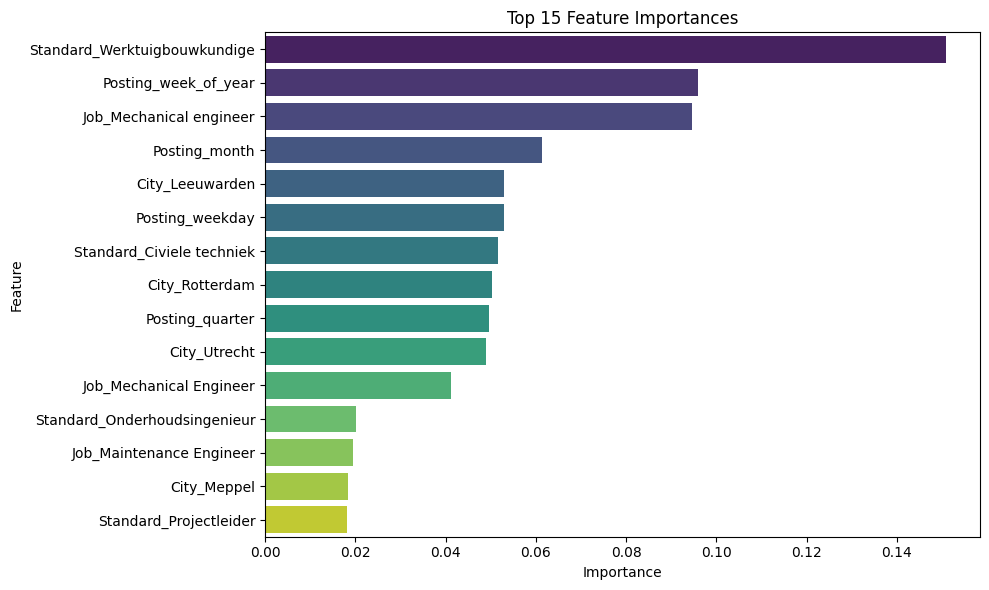

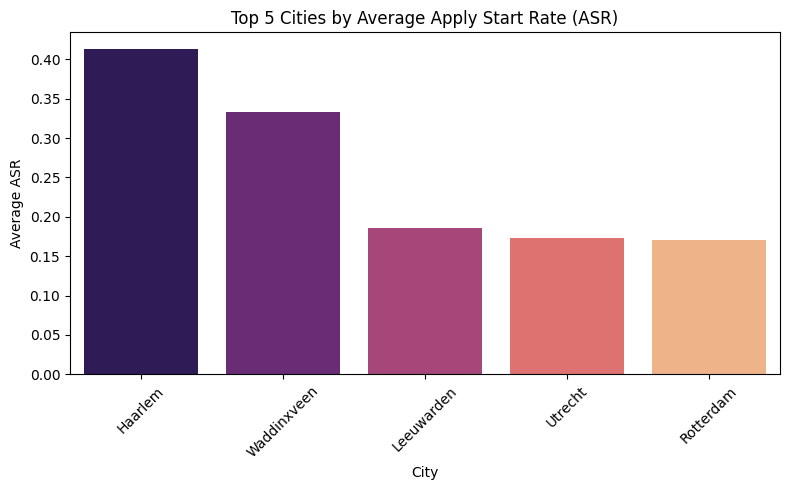

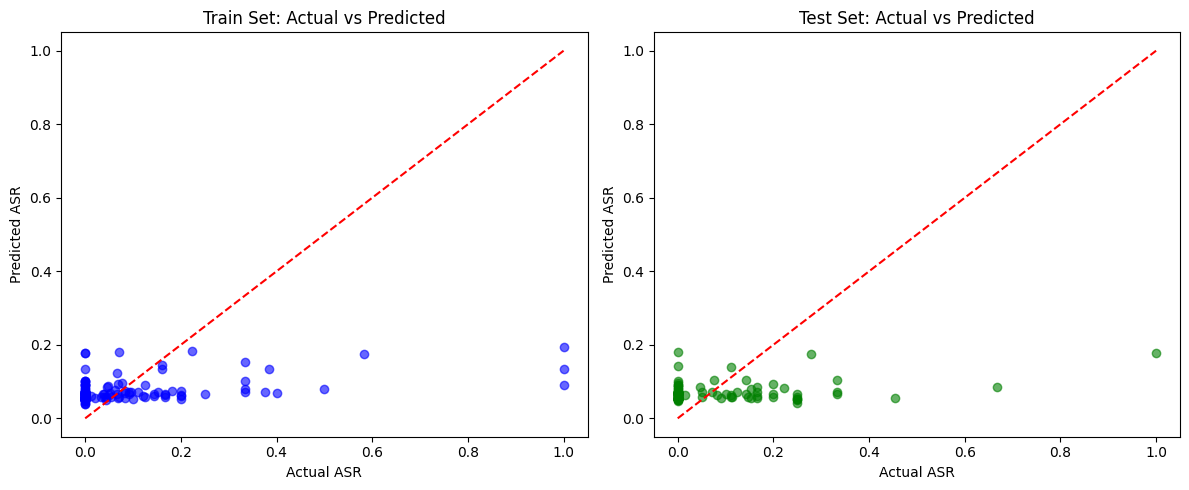

In [ ]:
# Corrected but with standard

# =========================
# Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# =========================
# Load dataset
# =========================
df = pd.read_csv("Map2.csv", sep=";", encoding="latin1")

# =========================
# Initial exploration
# =========================
print("First 5 rows:\n", df.head())
print("\nColumns:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())

# =========================
# Rename columns (for simplicity, remove spaces and special characters)
# =========================
df = df.rename(columns=lambda x: x.strip().replace(" ", "_")
                                  .replace("/", "_")
                                  .replace("(", "")
                                  .replace(")", ""))
print("\nRenamed columns:\n", df.columns)

# =========================
# Drop duplicates
# =========================
df = df.drop_duplicates()
print(f"\nNumber of rows after removing duplicates: {df.shape[0]}")

# =========================
# Keep only realistic features
# =========================
categorical_features = ["Job", "City", "Standard"]  # Added Standard
target = "Apply_start_rate_ASR"

# =========================================================
# Data quality filtering
# =========================================================

# Convert Created to datetime
df["Created"] = pd.to_datetime(df["Created"], errors="coerce", dayfirst=True)

# Drop all rows with missing values
df = df.dropna(subset=categorical_features + ["Created", target])

# =========================
# Feature engineering from date
# =========================
df["Posting_month"] = df["Created"].dt.month
df["Posting_weekday"] = df["Created"].dt.weekday
df["Posting_quarter"] = df["Created"].dt.quarter
df["Posting_week_of_year"] = df["Created"].dt.isocalendar().week

numerical_features = [
    "Posting_month",
    "Posting_weekday",
    "Posting_quarter",
    "Posting_week_of_year"
]

# =========================
# Train-test split
# =========================
X = df[categorical_features + numerical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# =========================
# Preprocessing
# =========================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

# =========================
# Random Forest model (tuned)
# =========================
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,           # limit depth
    max_features="sqrt",   # consider sqrt features per split
    min_samples_leaf=3,    # min samples per leaf
    random_state=42,
    n_jobs=-1
)

# =========================
# Pipeline
# =========================
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", rf_model)
    ]
)

# =========================
# Train model
# =========================
model.fit(X_train, y_train)

# =========================
# Evaluation
# =========================
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train metrics
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\n--- Model Evaluation ---")
print(f"Train R² score: {r2_train:.4f}")
print(f"Train Mean Squared Error (MSE): {mse_train:.6f}")
print(f"Test R² score: {r2_test:.4f}")
print(f"Test Mean Squared Error (MSE): {mse_test:.6f}")

# =========================================================
# Cross-validation (stability check)
# =========================================================
cv_scores = cross_val_score(
    model, X, y,
    cv=5,
    scoring="r2"
)

print("\nCross-validated R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

# =========================
# Feature importance
# =========================
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([cat_feature_names, numerical_features])

importances = model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), hue=feature_importance_df.head(15)['Feature'], legend=False, palette="viridis")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# =========================
# Top 5 Cities by Average ASR
# =========================
top_cities = df.groupby("City")[target].mean().sort_values(ascending=False).head(5)
plt.figure(figsize=(8,5))
sns.barplot(x=top_cities.index, y=top_cities.values, hue=top_cities.index, legend=False, palette="magma")
plt.title("Top 5 Cities by Average Apply Start Rate (ASR)")
plt.ylabel("Average ASR")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# Predicted vs Actual Plot (Train + Test)
# =========================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual ASR")
plt.ylabel("Predicted ASR")
plt.title("Train Set: Actual vs Predicted")

plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual ASR")
plt.ylabel("Predicted ASR")
plt.title("Test Set: Actual vs Predicted")

plt.tight_layout()
plt.show()


## Test 4 – Random Forest Predicting Clickthrough Rate (CTR)

### Objective
Test whether CTR is more predictable than ASR.

### Target
- Clickthrough Rate (CTR)

### Features
- Job
- City
- Standardized Job Title
- Temporal features

### Results
- Train R² ≈ 0.34  
- Test R² ≈ 0.21  
- CV R² still unstable

### Interpretation
CTR shows stronger signal than ASR.  
However, Random Forest still struggles with:
- Sparse categorical data
- Limited sample size

### Conclusion
CTR is selected as the preferred target metric going forward.


First 5 rows:
                                     Job           Standard      Country  \
0                        Accountmanager     Accountmanager  Netherlands   
1                        Accountmanager     Accountmanager  Netherlands   
2                        Accountmanager     Accountmanager  Netherlands   
3  Traineeship Technische Bedrijfskunde  Bedrijfsbeheerder  Netherlands   
4  Traineeship Technische Bedrijfskunde  Bedrijfsbeheerder  Netherlands   

          State/Region        City  Impressions  Clicks  Apply starts  \
0  Utrecht (provincie)  Amersfoort        543.0    51.0           1.0   
1  Utrecht (provincie)  Amersfoort        291.0    26.0           0.0   
2  Utrecht (provincie)  Amersfoort        223.0    29.0           2.0   
3           Overijssel   Steenwijk         72.0     4.0           0.0   
4        Noord-Holland     Schagen         74.0     6.0           0.0   

   Applies Cost per click (CPC)  ... Apply completion rate (ACR)  \
0      0.0                 

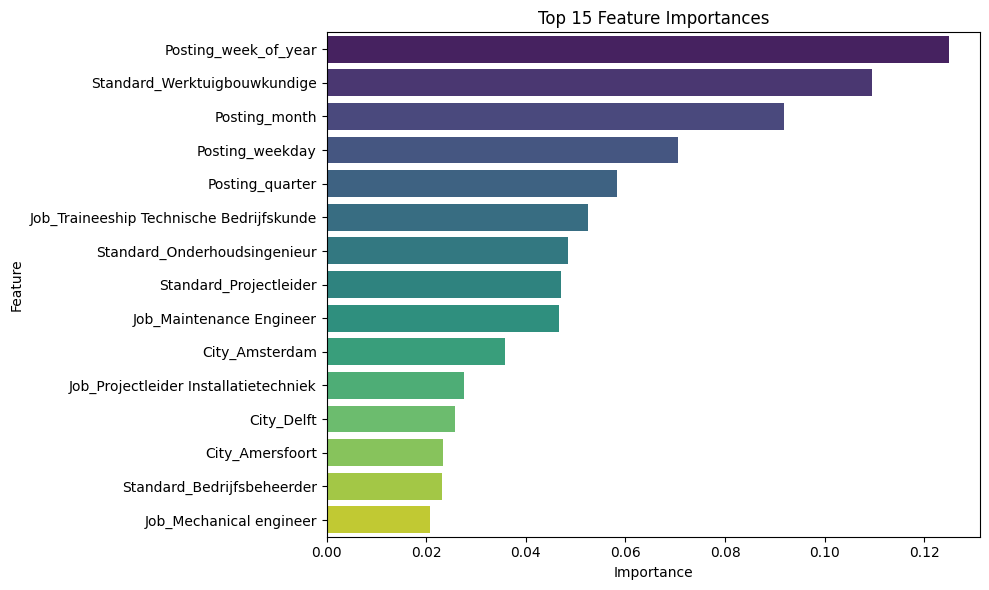

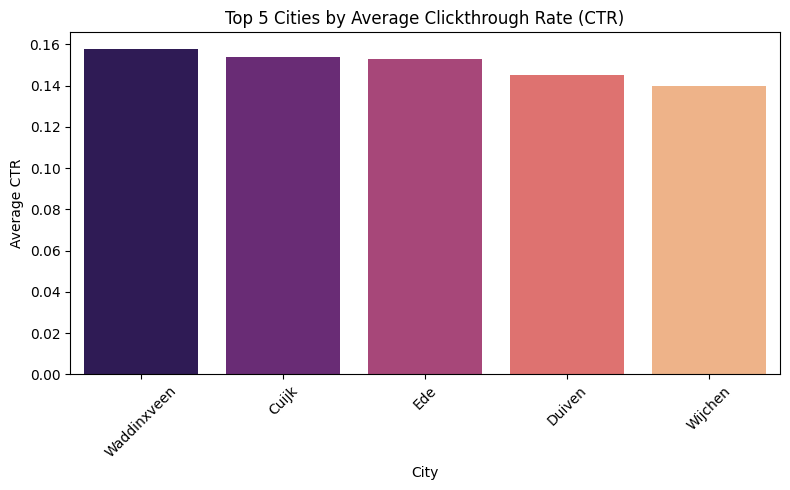

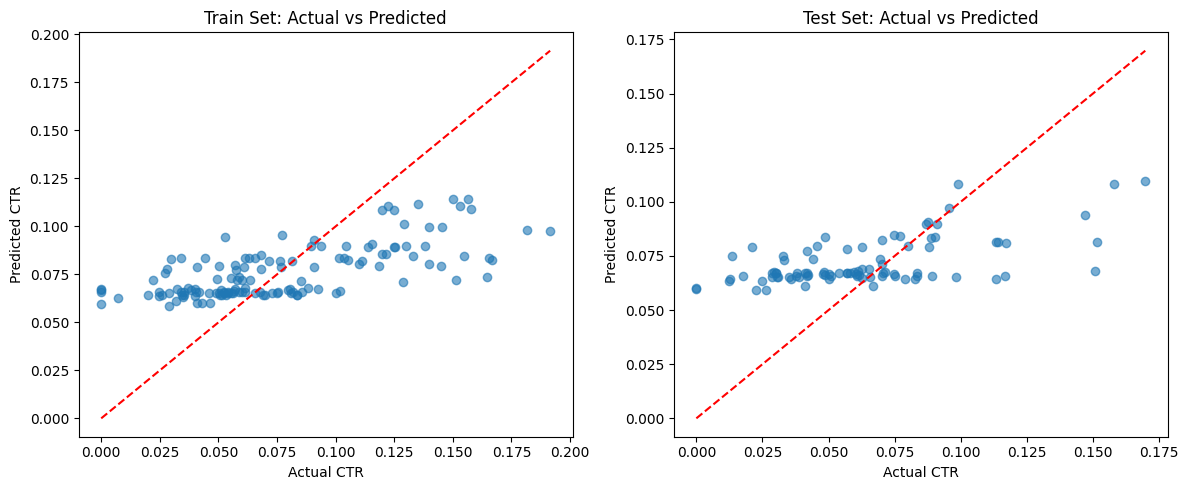

In [ ]:
# Corrected but with standard and target = Clickthrough_rate_CTR

# =========================================================
# Imports
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# =========================================================
# Load dataset
# =========================================================
df = pd.read_csv("Map2.csv", sep=";", encoding="latin1")

# =========================================================
# 3. Initial exploration
# =========================================================
print("First 5 rows:\n", df.head())
print("\nColumns:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())

# =========================================================
# Rename columns for (for simplicity, remove spaces and special characters)
# =========================================================
df = df.rename(columns=lambda x: x.strip()
                                  .replace(" ", "_")
                                  .replace("/", "_")
                                  .replace("(", "")
                                  .replace(")", ""))
print("\nRenamed columns:\n", df.columns)

# =========================
# Drop duplicates
# =========================
df = df.drop_duplicates()
print(f"\nNumber of rows after removing duplicates: {df.shape[0]}")

# =========================================================
# Feature & target selection
# =========================================================
categorical_features = ["Job", "City", "Standard"]
target = "Clickthrough_rate_CTR"

# =========================================================
# Data quality filtering
# =========================================================

# Remove extreme CTR values (unstable ratios)
df = df[df[target] <= 0.2]

# Minimum impressions threshold
df = df[df["Impressions"] >= 30]

# Convert Created to datetime
df["Created"] = pd.to_datetime(df["Created"], errors="coerce", dayfirst=True)

# Drop rows with missing required values
df = df.dropna(subset=categorical_features + ["Created", target])

# =========================================================
# Feature engineering from date
# =========================================================
df["Posting_month"] = df["Created"].dt.month
df["Posting_weekday"] = df["Created"].dt.weekday
df["Posting_quarter"] = df["Created"].dt.quarter
df["Posting_week_of_year"] = df["Created"].dt.isocalendar().week.astype(int)

numerical_features = [
    "Posting_month",
    "Posting_weekday",
    "Posting_quarter",
    "Posting_week_of_year"
]

# =========================================================
# Train-test split
# =========================================================
X = df[categorical_features + numerical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# =========================================================
# Preprocessing
# =========================================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

# =========================================================
# Random Forest model
# =========================================================
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,           # limit depth
    max_features="sqrt",   # consider sqrt features per split
    min_samples_leaf=3,    # min samples per leaf
    random_state=42,
    n_jobs=-1
)

# =========================================================
# Pipeline
# =========================================================
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", rf_model)
    ]
)

# =========================================================
# Train model
# =========================================================
model.fit(X_train, y_train)

# =========================================================
# Evaluation
# =========================================================
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train metrics
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\n--- Model Evaluation ---")
print(f"Train R² score: {r2_train:.4f}")
print(f"Train Mean Squared Error (MSE): {mse_train:.6f}")
print(f"Test R² score: {r2_test:.4f}")
print(f"Test Mean Squared Error (MSE): {mse_test:.6f}")

# =========================================================
# Cross-validation (stability check)
# =========================================================
cv_scores = cross_val_score(
    model, X, y,
    cv=5,
    scoring="r2"
)

print("\nCross-validated R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

# =========================================================
# Feature importance
# =========================================================
ohe = model.named_steps["preprocessor"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([cat_feature_names, numerical_features])

importances = model.named_steps["regressor"].feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df.head(15), 
    hue=feature_importance_df.head(15)["Feature"], 
    legend=False,
    palette="viridis"
)
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# =========================================================
# Top 5 Cities by Average CTR
# =========================================================
top_cities = (
    df.groupby("City")[target]
      .mean()
      .sort_values(ascending=False)
      .head(5)
)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=top_cities.index,
    y=top_cities.values,
    hue=top_cities.index,
    legend=False,
    palette="magma"
)
plt.title("Top 5 Cities by Average Clickthrough Rate (CTR)")
plt.ylabel("Average CTR")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================================================
# Predicted vs Actual (Train & Test)
# =========================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    "r--"
)
plt.xlabel("Actual CTR")
plt.ylabel("Predicted CTR")
plt.title("Train Set: Actual vs Predicted")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--"
)
plt.xlabel("Actual CTR")
plt.ylabel("Predicted CTR")
plt.title("Test Set: Actual vs Predicted")

plt.tight_layout()
plt.show()


## Test 5 – XGBoost Model (Overfitting Observed)

### Objective
Evaluate whether a more powerful model improves performance.

### Target
- Clickthrough Rate (CTR)

### Model
- XGBoost Regressor

### Results
- Train R² ≈ 0.95  
- Test R² ≈ 0.14  
- Mean CV R² < -0.30

### Interpretation
XGBoost heavily overfits due to:
- High model complexity
- Small dataset
- High-cardinality categorical features

### Conclusion
More complex models worsen generalization.  
Model complexity must match data quality.


First 5 rows:
                                     Job           Standard      Country  \
0                        Accountmanager     Accountmanager  Netherlands   
1                        Accountmanager     Accountmanager  Netherlands   
2                        Accountmanager     Accountmanager  Netherlands   
3  Traineeship Technische Bedrijfskunde  Bedrijfsbeheerder  Netherlands   
4  Traineeship Technische Bedrijfskunde  Bedrijfsbeheerder  Netherlands   

          State/Region        City  Impressions  Clicks  Apply starts  \
0  Utrecht (provincie)  Amersfoort        543.0    51.0           1.0   
1  Utrecht (provincie)  Amersfoort        291.0    26.0           0.0   
2  Utrecht (provincie)  Amersfoort        223.0    29.0           2.0   
3           Overijssel   Steenwijk         72.0     4.0           0.0   
4        Noord-Holland     Schagen         74.0     6.0           0.0   

   Applies Cost per click (CPC)  ... Apply completion rate (ACR)  \
0      0.0                 

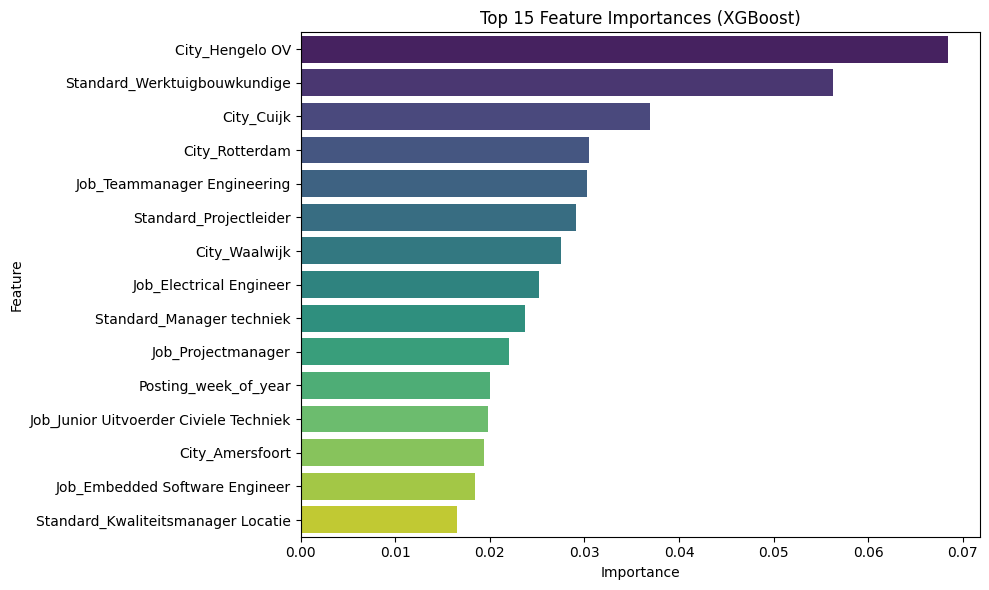

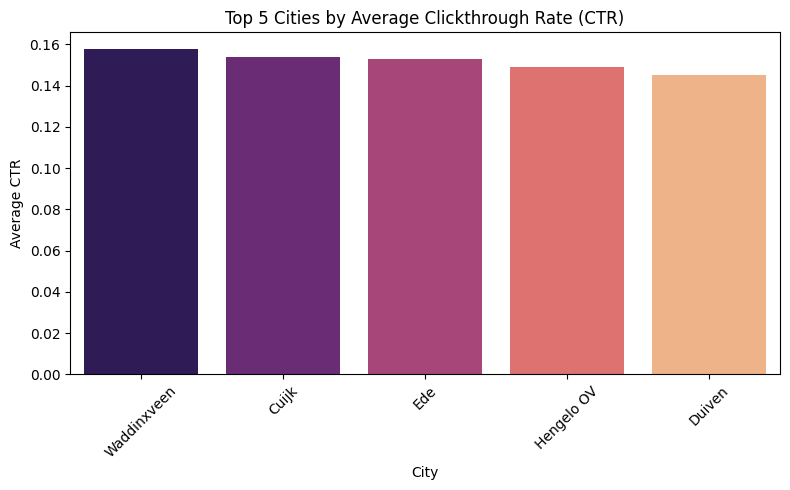

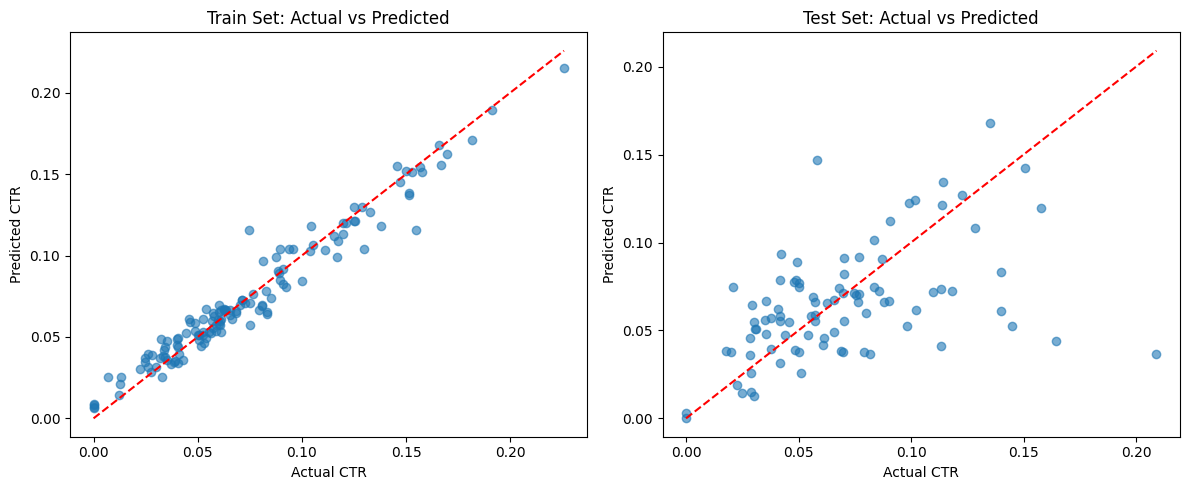

In [ ]:
# Corrected but with standard and target = Clickthrough_rate_CTR and using model XGBoost
# model is overfitting

# =========================================================
# Imports
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

# =========================================================
# Load dataset
# =========================================================
df = pd.read_csv("Map2.csv", sep=";", encoding="latin1")

# =========================================================
# Initial exploration
# =========================================================
print("First 5 rows:\n", df.head())
print("\nColumns:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())

# =========================================================
# Rename columns for convenience
# =========================================================
df = df.rename(columns=lambda x: x.strip()
                                  .replace(" ", "_")
                                  .replace("/", "_")
                                  .replace("(", "")
                                  .replace(")", ""))
print("\nRenamed columns:\n", df.columns)

# =========================================================
# Feature & target selection
# =========================================================
categorical_features = ["Job","City", "Standard"]
target = "Clickthrough_rate_CTR"

# =========================================================
# Data quality filtering
# =========================================================

# Remove extreme CTR values (unstable ratios)
df = df[df[target] <= 0.4]

# Minimum impressions threshold
df = df[df["Impressions"] >= 30]

# Convert Created to datetime
df["Created"] = pd.to_datetime(df["Created"], errors="coerce", dayfirst=True)

# Drop rows with missing required values
df = df.dropna(subset=categorical_features + ["Created", target])

# =========================================================
# Feature engineering from date
# =========================================================
df["Posting_month"] = df["Created"].dt.month
df["Posting_weekday"] = df["Created"].dt.weekday
df["Posting_quarter"] = df["Created"].dt.quarter
df["Posting_week_of_year"] = df["Created"].dt.isocalendar().week.astype(int)

numerical_features = [
    "Posting_month",
    "Posting_weekday",
    "Posting_quarter",
    "Posting_week_of_year"
]

# =========================================================
# Train-test split
# =========================================================
X = df[categorical_features + numerical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# =========================================================
# Preprocessing
# =========================================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

# =========================================================
# XGBoost model
# =========================================================
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# =========================================================
# Pipeline
# =========================================================
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", xgb_model)
    ]
)

# =========================================================
# Train model
# =========================================================
model.fit(X_train, y_train)

# =========================================================
# Evaluation
# =========================================================
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train metrics
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\n--- Model Evaluation (XGBoost) ---")
print(f"Train R² score: {r2_train:.4f}")
print(f"Train Mean Squared Error (MSE): {mse_train:.6f}")
print(f"Test R² score: {r2_test:.4f}")
print(f"Test Mean Squared Error (MSE): {mse_test:.6f}")

# =========================================================
# Cross-validation (stability check)
# =========================================================
cv_scores = cross_val_score(
    model, X, y,
    cv=5,
    scoring="r2"
)

print("\nCross-validated R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

# =========================================================
# Feature importance
# =========================================================
ohe = model.named_steps["preprocessor"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([cat_feature_names, numerical_features])

importances = model.named_steps["regressor"].feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df.head(15), 
    hue=feature_importance_df.head(15)["Feature"], 
    legend=False,
    palette="viridis"
)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

# =========================================================
# Top 5 Cities by Average CTR
# =========================================================
top_cities = (
    df.groupby("City")[target]
      .mean()
      .sort_values(ascending=False)
      .head(5)
)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=top_cities.index,
    y=top_cities.values, 
    hue=top_cities.index,
    legend=False,
    palette="magma"
)
plt.title("Top 5 Cities by Average Clickthrough Rate (CTR)")
plt.ylabel("Average CTR")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================================================
# Predicted vs Actual (Train & Test)
# =========================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    "r--"
)
plt.xlabel("Actual CTR")
plt.ylabel("Predicted CTR")
plt.title("Train Set: Actual vs Predicted")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--"
)
plt.xlabel("Actual CTR")
plt.ylabel("Predicted CTR")
plt.title("Test Set: Actual vs Predicted")

plt.tight_layout()
plt.show()


## Test 6 – Ridge Regression (Best Performing Model)

### Objective
Test a simpler, regularized model suitable for sparse data.

### Target
- Clickthrough Rate (CTR)

### Model
- Ridge Regression with L2 regularization

### Results
- Train R² ≈ 0.57  
- Test R² ≈ 0.35  
- Best generalization among all valid models

### Interpretation
Ridge Regression performs best because:
- Linear assumptions match weak signal
- Regularization reduces overfitting
- Handles one-hot encoded categorical data well

### Conclusion
Ridge Regression is the most appropriate model given the current dataset.


First 5 rows:
                                     Job           Standard      Country  \
0                        Accountmanager     Accountmanager  Netherlands   
1                        Accountmanager     Accountmanager  Netherlands   
2                        Accountmanager     Accountmanager  Netherlands   
3  Traineeship Technische Bedrijfskunde  Bedrijfsbeheerder  Netherlands   
4  Traineeship Technische Bedrijfskunde  Bedrijfsbeheerder  Netherlands   

          State/Region        City  Impressions  Clicks  Apply starts  \
0  Utrecht (provincie)  Amersfoort        543.0    51.0           1.0   
1  Utrecht (provincie)  Amersfoort        291.0    26.0           0.0   
2  Utrecht (provincie)  Amersfoort        223.0    29.0           2.0   
3           Overijssel   Steenwijk         72.0     4.0           0.0   
4        Noord-Holland     Schagen         74.0     6.0           0.0   

   Applies Cost per click (CPC)  ... Apply completion rate (ACR)  \
0      0.0                 

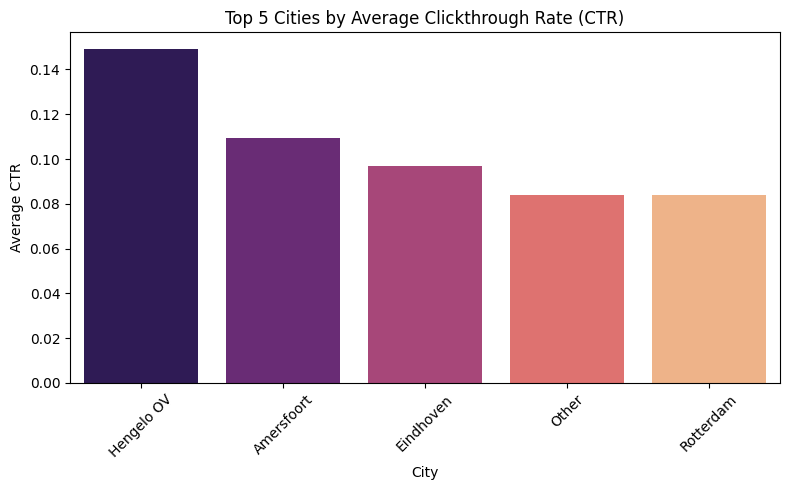

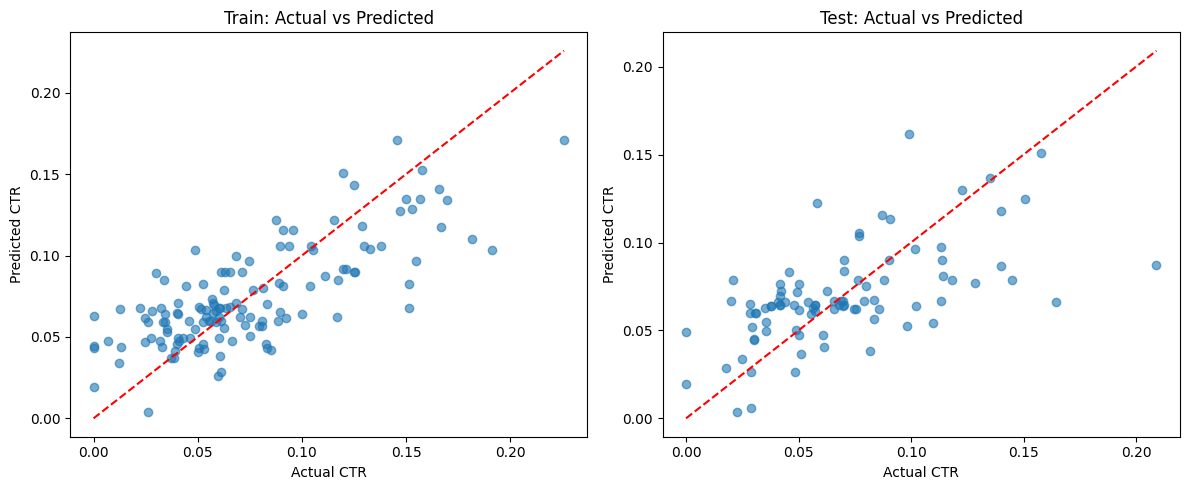

In [ ]:
# Best working model: Ridge Regression with standard and target = Clickthrough_rate_CTR

# =========================================================
# Imports
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge

# =========================================================
# Load dataset
# =========================================================
df = pd.read_csv("Map2.csv", sep=";", encoding="latin1")

# =========================================================
# Initial exploration
# =========================================================
print("First 5 rows:\n", df.head())
print("\nColumns:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())

# =========================================================
# Rename columns
# =========================================================
df = df.rename(columns=lambda x: x.strip()
                                  .replace(" ", "_")
                                  .replace("/", "_")
                                  .replace("(", "")
                                  .replace(")", ""))
print("\nRenamed columns:\n", df.columns)

# =========================================================
# Drop duplicates
# =========================================================
df = df.drop_duplicates()
print(f"\nNumber of rows after removing duplicates: {df.shape[0]}")

# =========================================================
# Feature & target selection
# =========================================================
categorical_features = ["Job", "City", "Standard"]
target = "Clickthrough_rate_CTR"

# =========================================================
# Data quality filtering
# =========================================================

# Remove extreme CTR values (unstable ratios)
df = df[df[target] <= 0.4]

# Minimum impressions threshold
df = df[df["Impressions"] >= 30]

# Convert Created to datetime
df["Created"] = pd.to_datetime(df["Created"], errors="coerce", dayfirst=True)

# Drop rows with missing required values
df = df.dropna(subset=categorical_features + ["Created", target])

# Reduce categorical cardinality (IMPORTANT)
min_freq = 5
for col in categorical_features:
    freq = df[col].value_counts()
    rare = freq[freq < min_freq].index
    df[col] = df[col].replace(rare, "Other")

# =========================================================
# Feature engineering from date
# =========================================================
df["Posting_month"] = df["Created"].dt.month
df["Posting_weekday"] = df["Created"].dt.weekday
df["Posting_quarter"] = df["Created"].dt.quarter
df["Posting_week_of_year"] = df["Created"].dt.isocalendar().week.astype(int)

numerical_features = [
    "Posting_month",
    "Posting_weekday",
    "Posting_quarter",
    "Posting_week_of_year"
]

# =========================================================
# Train-test split
# =========================================================
X = df[categorical_features + numerical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# =========================================================
# Preprocessing
# =========================================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

# =========================================================
# Ridge Regression model
# =========================================================
ridge_model = Ridge(alpha=1.0)

# =========================================================
# Pipeline
# =========================================================
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", ridge_model)
    ]
)

# =========================================================
# Train model
# =========================================================
model.fit(X_train, y_train)

# =========================================================
# Evaluation
# =========================================================
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train metrics
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\n--- Model Evaluation ---")
print(f"Train R² score: {r2_train:.4f}")
print(f"Train Mean Squared Error (MSE): {mse_train:.6f}")
print(f"Test R² score: {r2_test:.4f}")
print(f"Test Mean Squared Error (MSE): {mse_test:.6f}")

# =========================================================
# Cross-validation (stability check)
# =========================================================
cv_scores = cross_val_score(
    model, X, y,
    cv=5,
    scoring="r2"
)

print("\nCross-validated R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

# =========================================================
# Top 5 Cities by Average CTR
# =========================================================
top_cities = (
    df.groupby("City")[target]
      .mean()
      .sort_values(ascending=False)
      .head(5)
)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=top_cities.index,
    y=top_cities.values,
    hue=top_cities.index,
    legend=False,
    palette="magma"
)
plt.title("Top 5 Cities by Average Clickthrough Rate (CTR)")
plt.ylabel("Average CTR")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# =========================================================
# Predicted vs Actual (Train & Test)
# =========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], 'r--')
plt.title("Train: Actual vs Predicted")
plt.xlabel("Actual CTR")
plt.ylabel("Predicted CTR")

plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.title("Test: Actual vs Predicted")
plt.xlabel("Actual CTR")
plt.ylabel("Predicted CTR")

plt.tight_layout()
plt.show()


## Cross-Validation Insights

Across all tests, cross-validation R² scores are low or negative.

This is expected due to:
- Small sample size
- Category sparsity
- Unseen categories across folds

Low CV scores indicate **data instability**, not incorrect modeling.

---

## Exploratory Data Analysis and Feature Insights

Feature importance and aggregated analysis consistently show:
- City and Job explain most variance
- Standardized job titles improve signal
- Temporal features contribute minimally

EDA is therefore essential for:
- Feature selection
- Target metric choice
- Model selection decisions



Aggregated Feature Importance:
    Feature  Importance
1      City    0.386777
0       Job    0.302163
2  Standard    0.266243
3   Created    0.024838


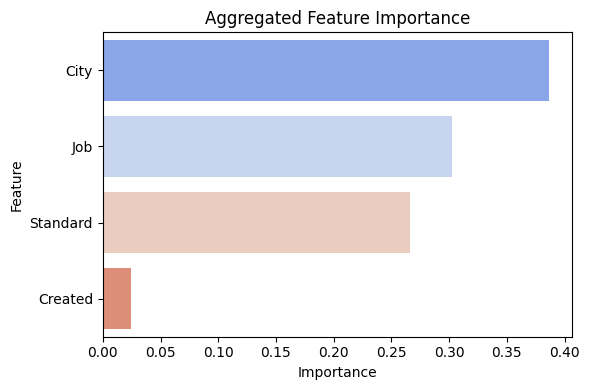

In [10]:
# =========================
# Aggregate importance by main variable
# =========================

# Identify dummy prefixes
job_cols = [f for f in all_feature_names if f.startswith("Job_")]
city_cols = [f for f in all_feature_names if f.startswith("City_")]
standard_cols = [f for f in all_feature_names if f.startswith("Standard_")]
created_cols = ["Posting_month", "Posting_weekday", "Posting_quarter"]

# Helper function to sum importance safely
def sum_importance(cols, feature_names, importances):
    idx = [np.where(feature_names == c)[0][0] for c in cols if c in feature_names]
    return importances[idx].sum() if len(idx) > 0 else 0

# Sum importance per variable
job_importance = sum_importance(job_cols, all_feature_names, importances)
city_importance = sum_importance(city_cols, all_feature_names, importances)
standard_importance = sum_importance(standard_cols, all_feature_names, importances)
created_importance = sum_importance(created_cols, all_feature_names, importances)

# Create dataframe
agg_importance_df = pd.DataFrame({
    "Feature": ["Job", "City", "Standard", "Created"],
    "Importance": [
        job_importance,
        city_importance,
        standard_importance,
        created_importance
    ]
}).sort_values(by="Importance", ascending=False)

print("\nAggregated Feature Importance:")
print(agg_importance_df)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(
    x="Importance",
    y="Feature",
    data=agg_importance_df,
    hue="Feature",
    legend=False,
    palette="coolwarm"
)
plt.title("Aggregated Feature Importance")
plt.tight_layout()
plt.show()

## Opportunities for Predictive Analytics

- CTR is more predictable than ASR (there is still a discusion to have if CTR is better to use then ASR in practice)
- Standardization improves aggregation
- Linear models are currently best suited

With additional data, the following become feasible:
- More reliable forecasting
- Use of non-linear models
- Campaign performance optimization before publishing

---

## Final Conclusion

This project demonstrates:
- Proper data aggregation and preparation
- Transparent modeling iterations
- Critical evaluation of model limitations

The main limitation is **data quality and quantity**, not modeling technique.  
Ridge Regression provides the best balance between bias and variance for this dataset.
